In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

In [ ]:
from DomainPrediction.esm.esm2 import ESM2
from DomainPrediction.al.confit import ESM2ConFit

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM
from DomainPrediction.al.confit import ESMCConFit

#### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Tdomain'

In [7]:
file = os.path.join(data_path, 'dataset_tdomain.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [9]:
results_file = os.path.join(data_path, 'results_tdomain_confit.csv')

In [10]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [11]:
df_results.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log,pred_ESM650M_confit,pred_ESMC300M_confit,pred_ESMC600M_confit
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000,0.000000,0.000000,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670,-0.163567,-0.115234,3.343750
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841,-4.698332,1.311523,6.815430
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547,-11.521654,-18.805664,-19.704224
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059,-3.644320,-9.452637,-8.261597


In [12]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_ESM650M_confit', 'pred_ESMC300M_confit', 'pred_ESMC600M_confit'], dtype='object')

In [13]:
len(df_results.columns[df_results.columns.str.contains('pred')])

3

In [14]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### OHE

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_ridge'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_RF'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_RF'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_RF'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [2300, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 10,
        'early_stopping': False,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_MLP'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_MLP'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_MLP'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3 and ESMC Embeddings

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
# esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
# embeddings = esm2.get_embeddings_cls(df['seq'])
# embeddings = esm3.get_embeddings_cls(df['seq'])
# embeddings = esmc.get_embeddings_cls(df['seq'])

In [ ]:
embeddings.shape

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_concat_ridge'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_concat_RF'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_RF'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_RF'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [1280, 512, 1], 
        'epoch': 500, 
        'batch_size': 16,
        'patience': 500,
        'early_stopping': True,
        'lr': 1e-4,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESM650M_cls_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESM650M_cls_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESM650M_cls_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - perplexities

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
# esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
y_pred = []
for seq in tqdm(df['seq']):
    # perplexity = esm2.compute_perplexity(seq)
    # perplexity = esm3.compute_perplexity(seq)
    # perplexity = esmc.compute_perplexity(seq)
    y_pred.append(perplexity)

y_pred = np.array(y_pred)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].plot(y, -y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, -y_pred)
corr = stats.spearmanr(y, -y_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mask = ~(df['fitness_raw'] == 0)
ax[1].plot(y[mask], -y_pred[mask], '.', alpha=0.5)
mse = mean_squared_error(y[mask], -y_pred[mask])
corr = stats.spearmanr(y[mask], -y_pred[mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
assert y_pred.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_perplexity'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_perplexity'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_perplexity'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - ZeroShot Margiaals

In [ ]:
# from DomainPrediction.utils.constants import *

In [ ]:
# gxps_wt = helper.read_fasta('/nethome/kgeorge/workspace/DomainPrediction/Data/gxps/GxpS_ATC.fasta', mode='str')[0]
# A_domain_wt = ''.join([s for i, s in enumerate(gxps_wt) if i in A_gxps_atc])
# C_domain_wt = ''.join([s for i, s in enumerate(gxps_wt) if i in C_gxps_atc])
# TplusLinker_wt = ''.join([s for i, s in enumerate(gxps_wt) if i not in A_gxps_atc+C_gxps_atc])

In [ ]:
# assert TplusLinker_wt == df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
# df['TplusLinker'] = df['seq']

In [ ]:
# assert gxps_wt ==  A_domain_wt + TplusLinker_wt + C_domain_wt

In [ ]:
# df['seq'] = df['seq'].apply(lambda x: A_domain_wt+x+C_domain_wt)

In [ ]:
# df.head()

In [ ]:
# assert gxps_wt == df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
# esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
# ## wt marginals
# # wt_log_prob = esm2.get_log_prob(wt_sequence)
# # wt_log_prob = esm3.get_log_prob(wt_sequence)
# wt_log_prob = esmc.get_log_prob(wt_sequence)
# y_pred = []
# for i, row in tqdm(df.iterrows()):
#     mt_sequence = row['seq']
#     # score, n_muts = esm2.get_wildtype_marginal(mt_sequence, wt_sequence, wt_log_prob)
#     # score, n_muts = esm3.get_wildtype_marginal(mt_sequence, wt_sequence, wt_log_prob)
#     score, n_muts = esmc.get_wildtype_marginal(mt_sequence, wt_sequence, wt_log_prob)

#     assert n_muts == row['n_mut']

#     y_pred.append(score)

# y_pred = np.array(y_pred)

In [ ]:
# ## masked marginals
# y_pred = []
# for i, row in tqdm(df.iterrows()):
#     mt_sequence = row['seq']
#     # score, n_muts = esm2.get_masked_marginal(mt_sequence, wt_sequence)
#     # score, n_muts = esm3.get_masked_marginal(mt_sequence, wt_sequence)
#     score, n_muts = esmc.get_masked_marginal(mt_sequence, wt_sequence)

#     assert n_muts == row['n_mut']

#     y_pred.append(score)

# y_pred = np.array(y_pred)

In [ ]:
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].plot(y, y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, y_pred)
corr = stats.spearmanr(y, y_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Full Dataset \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mask = ~(df['fitness_raw'] == 0)
ax[1].plot(y[mask], y_pred[mask], '.', alpha=0.5)
mse = mean_squared_error(y[mask], y_pred[mask])
corr = stats.spearmanr(y[mask], y_pred[mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Omit fitness = 0 \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
plt.figure(figsize=(3, 3))
_ = df['n_mut'].hist()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

mask_muts = (df['n_mut'] < 20)

ax[0].plot(y[mask_muts], y_pred[mask_muts], '.', alpha=0.5)
mse = mean_squared_error(y[mask_muts], y_pred[mask_muts])
corr = stats.spearmanr(y[mask_muts], y_pred[mask_muts])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'n mutations < 20 \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')


ax[1].plot(y[~mask_muts], y_pred[~mask_muts], '.', alpha=0.5)
mse = mean_squared_error(y[~mask_muts], y_pred[~mask_muts])
corr = stats.spearmanr(y[~mask_muts], y_pred[~mask_muts])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'n mutations > 20 \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

mask_muts = (df['n_mut'] < 20)
mask_omit = ~(df['fitness_raw'] == 0)

ax[0].plot(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit], '.', alpha=0.5)
mse = mean_squared_error(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit])
corr = stats.spearmanr(y[mask_muts & mask_omit], y_pred[mask_muts & mask_omit])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

ax[1].plot(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit], '.', alpha=0.5)
mse = mean_squared_error(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit])
corr = stats.spearmanr(y[~mask_muts & mask_omit], y_pred[~mask_muts & mask_omit])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ATC_ESMC600M_wt_marginal'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ATC_ESMC600M_wt_marginal'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ATC_ESMC600M_wt_marginal'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ATC_ESMC600M_masked_marginal'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ATC_ESMC600M_masked_marginal'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ATC_ESMC600M_masked_marginal'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ConFit - Contrastive Fitness Learning

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
# config={'model_path': '/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt',
#         'epoch': 30, 
#         'batch_size': 8,
#         'lambda': 0.1,
#         'accumulate_batch_size': 32,
#         'patience': 20,
#         'early_stopping': False,
#         'lr': 5e-4,
#         'print_every_n_epoch': 1,
#         'device': 'gpu'}
# surrogate = ESM2ConFit(config=config)
# surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
config={'epoch': 30, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
# surrogate = ESMCConFit(name='esmc_300m', config=config)
surrogate = ESMCConFit(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
surrogate.sanity_check(df_train, wt_sequence)

In [ ]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
y_train_pred, y_train = y_pred[train_mask], y[train_mask]
y_val_pred, y_val = y_pred[val_mask], y[val_mask]
y_test_pred, y_test = y_pred[test_mask], y[test_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
omit_mask = df['fitness_raw'] != 0
y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
assert y_pred.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_confit'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_confit'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_confit'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### Changing WT to ESM3-2

In [15]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [31]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]
esm2_seq = df.loc[df['name'] == 'ESM2', 'seq'].iloc[0]

In [32]:
## masked marginals
y_pred_wt = []
y_pred_esm2 = []
muts_wt = []
muts_esm2 = []
for i, row in tqdm(df[df['name'].str.contains('ESM2')].iterrows()):
    mt_sequence = row['seq']
    score_wt, n_muts_wt = esmc.get_masked_marginal(mt_sequence, wt_sequence)
    score_esm2, n_muts_esm2 = esmc.get_masked_marginal(mt_sequence, esm2_seq)

    assert n_muts_wt == row['n_mut']

    y_pred_wt.append(score_wt)
    y_pred_esm2.append(score_esm2)
    muts_wt.append(n_muts_wt)
    muts_esm2.append(n_muts_esm2)


y_pred_wt = np.array(y_pred_wt)
y_pred_esm2 = np.array(y_pred_esm2)

25it [00:00, 27.01it/s]


In [33]:
y = df[df['name'].str.contains('ESM2')]['fitness_log'].to_numpy().astype(np.float32)

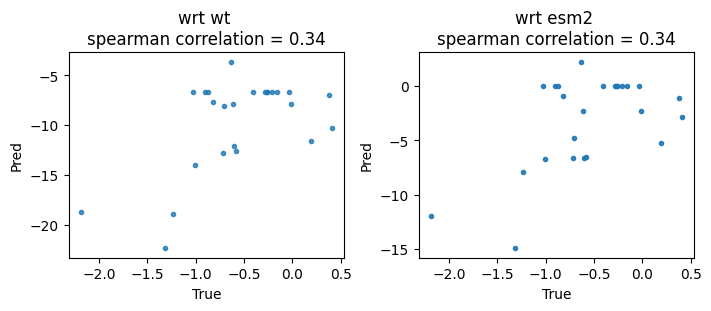

In [34]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].plot(y, y_pred_wt, '.', alpha=0.8)
corr = stats.spearmanr(y, y_pred_wt)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'wrt wt \nspearman correlation = {s_corr}')

ax[1].plot(y, y_pred_esm2, '.', alpha=0.9)
corr = stats.spearmanr(y, y_pred_esm2)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'wrt esm2 \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

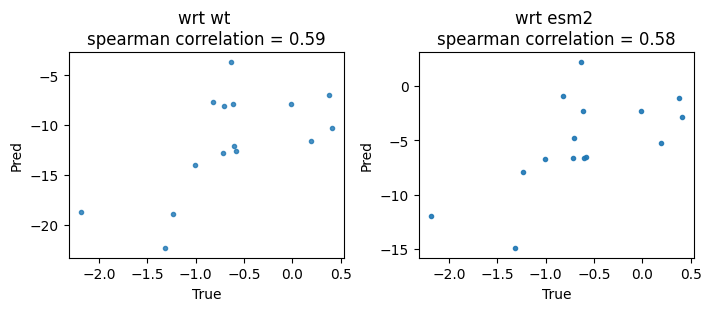

In [35]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

_mask = np.array(muts_esm2) != 0

ax[0].plot(y[_mask], y_pred_wt[_mask], '.', alpha=0.8)
corr = stats.spearmanr(y[_mask], y_pred_wt[_mask])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'wrt wt \nspearman correlation = {s_corr}')

ax[1].plot(y[_mask], y_pred_esm2[_mask], '.', alpha=0.9)
corr = stats.spearmanr(y[_mask], y_pred_esm2[_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'wrt esm2 \nspearman correlation = {s_corr}')

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

Text(0.5, 1.0, 'wrt esm2')

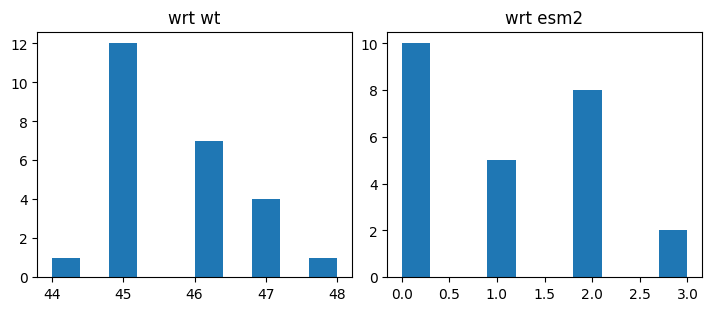

In [36]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

ax[0].hist(muts_wt)
ax[0].set_title(f'wrt wt')

ax[1].hist(muts_esm2)
ax[1].set_title(f'wrt esm2')